# Assignment 4 - Network analysis

### Peter Thramkrongart & Jakub Raszka

## Creating reusable network analysis pipeline





https://github.com/CDS-AU-DK/cds-language/blob/main/notebooks/session6.ipynb


Your script should be able to be run from the command line
It should take any weighted edgelist as an input, providing that edgelist is saved as a CSV with the column headers "nodeA", "nodeB"
For any given weighted edgelist given as an input, your script should be used to create a network visualization, which will be saved in a folder called viz.
It should also create a data frame showing the degree, betweenness, and eigenvector centrality for each node. It should save this as a CSV in a folder called output.


__Tips__

You should use argparse() in the Python standard library
Your code should contain a main() function
Don't worry too much about efficiency - networkx is really slow, there's no way around i!
If you have issues with pygraphviz, just use the built-in matplotlib functions in networkx.
You may want to create an argument for the user to define a cut-off point to filter data. E.g. only include node pairs with more than a certain edge weight.
Make sure to use all of the Python scripting skills you've learned so far, including in the workshops with Kristoffer Nielbo


__Bonus challenges__

Attempt to implement coreference resolution on entities (time-consuming)
Bundle your code up into a Python class, focusing on code modularity
Let the user define which graphing algorithm they use (pretty tricky)
Are there other ways of creating networks, rather than just document co-occurrence? (really tricky)


__General instructions__

For this assignment, you should upload a standalone .py script which can be executed from the command line
Save your script as network.py
You must include a requirements.txt file and a bash script to set up a virtual environment for the project. You can use those on worker02 as a template
You can either upload the scripts here or push to GitHub and include a link - or both!
Your code should be clearly documented in a way that allows others to easily follow the structure of your script and to use them from the command line


__Purpose__

This assignment is designed to test that you have an understanding of:

how to create command-line tools with Python;
how to perform network analysis using networkx;
how to create resuable and reproducible pipelines for data analysis.

__Packages__

In [231]:
import os # system tools
from csv import reader
import pandas as pd
from tqdm import tqdm #progression bar
import spacy
nlp = spacy.load("en_core_web_sm")

from itertools import combinations
from collections import Counter

import networkx as nx
import matplotlib.pyplot as plt

__Creating csv. df__


In [2]:
input_file = os.path.join("..", "data", "labelled_data", "fake_or_real_news.csv")
data = pd.read_csv(input_file)
real_df = data[data["label"] == "REAL"]["text"]

In [3]:
post_entities = []

for post in tqdm(real_df):
    # create a temporary list
    tmp_list = []
    #crate spaCy object
    doc = nlp(post)
    # for every named entity in the doc
    for entity in doc.ents:
        if entity.label_ == "PERSON":
            tmp_list.append(entity.text)
    # add tmp_list to main list
    post_entities.append(tmp_list)
    
    

100%|██████████| 3171/3171 [08:15<00:00,  6.40it/s]


In [5]:
edgelist = []

# iterate over every document
for doc in post_entities:
    # use combinations to create edgelist
    edges = list(combinations(doc, 2))
    # for each combination - e.g., each pair of "nodes"
    for edge in edges:
        # append this to final edgelist
        edgelist.append(tuple(sorted(edge)))

In [215]:
edgelist[:10]



[('John F. Kerry', 'Laurent Fabius'),
 ('Francois Hollande', 'John F. Kerry'),
 ('John F. Kerry', 'Kerry'),
 ('John F. Kerry', 'Obama'),
 ('John F. Kerry', 'Kerry'),
 ('John F. Kerry', 'Kerry'),
 ('Benjamin Netanyahu', 'John F. Kerry'),
 ('Jane Hartley', 'John F. Kerry'),
 ('John F. Kerry', 'Victoria Nuland'),
 ('Eric H. Holder Jr.', 'John F. Kerry')]

In [214]:
counted_edges = []

for pair, weight in Counter(edgelist).items():
    nodeA = pair[0]
    nodeB = pair[1]
    counted_edges.append((nodeA, nodeB, weight))

In [216]:
counted_edges[:10]

[('John F. Kerry', 'Laurent Fabius', 2),
 ('Francois Hollande', 'John F. Kerry', 1),
 ('John F. Kerry', 'Kerry', 19),
 ('John F. Kerry', 'Obama', 26),
 ('Benjamin Netanyahu', 'John F. Kerry', 7),
 ('Jane Hartley', 'John F. Kerry', 1),
 ('John F. Kerry', 'Victoria Nuland', 1),
 ('Eric H. Holder Jr.', 'John F. Kerry', 1),
 ('John F. Kerry', 'Narendra Modi', 1),
 ('Francois Hollande', 'Laurent Fabius', 1)]

In [218]:
edge_df = pd.DataFrame(counted_edges, columns = ["nodeA", "nodeB", "weight"])
edge_df.to_csv(os.path.join("..", "data", "assignment4", "edges_df.csv"))

In [11]:
edges_df = pd.DataFrame(counted_edges, columns = ["nodeA", "nodeB", "weight"])

In [13]:
pd.DataFrame.to_csv(edges_df, os.path.join("..", "data", "assignment4", "edges_df.csv"))

In [229]:
def main(input_file = os.path.join("..", "data", "assignment4", "edges_df.csv"), 
         output_file = os.path.join("..", "data", "assignment4", "output", "measures_of_centrality.csv"),
         threshold = 500, 
         graph_labels = False,
         plot = True,
         plot_file= os.path.join("..", "data", "assignment4", "viz","network_visualization.png")):
    
    data = pd.read_csv(input_file)
    print(f"{input_file} has succesfully been read")
    
    
    # filtering based on the set threshold
    filtered_df= data[data["weight"] > threshold]
    
    
    # calculating G
    G = nx.from_pandas_edgelist(filtered_df, "nodeA", "nodeB", ["weight"])
    
    if plot == True:  
        # plot it
        pos = nx.nx_agraph.graphviz_layout(G, prog = "neato")


        # draw, use matplot lib draw...
        nx.draw(G, pos, with_labels = graph_labels, node_size = 20, font_size = 10)
        plt.savefig(plot_file, dpi=300, bbox_inches="tight")
        print(f"{plot_file} has succesfully been saved")
    
    

    # filtered_df.head()
    centrality_df = pd.DataFrame()
    
    # degree centrality
    deg = nx.degree_centrality(G)
 
    # eigenvector
    ev = nx.eigenvector_centrality(G)

    # betweenness
    bc = nx.betweenness_centrality(G)
    
    centrality_df= {"node":deg.keys(),"degree":deg.values(),"betweenness":bc.values(),"eigenvector":ev.values()}
    centrality_df= pd.DataFrame(data =centrality_df)
    
    
    centrality_df.to_csv(output_file)
    print(f"{output_file} has succesfully been saved")
    

../data/assignment4/edges_df.csv has succesfully been read
../data/assignment4/viz/network_visualization.png has succesfully been saved
../data/assignment4/output/measures_of_centrality.csv has succesfully been saved


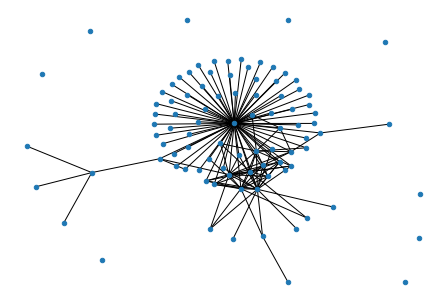

In [230]:
main()

In [41]:
def hello(**kwargs):
    print("hello")
    print(kwargs)

In [160]:
print(edge_df)

                     nodeA           nodeB
0            John F. Kerry  Laurent Fabius
1        Francois Hollande   John F. Kerry
2            John F. Kerry           Kerry
3            John F. Kerry           Obama
4            John F. Kerry           Kerry
...                    ...             ...
1290243      Fergus Cullen      Jeb Bush's
1290244               Bush   Fergus Cullen
1290245       Donald Trump      Jeb Bush's
1290246               Bush    Donald Trump
1290247               Bush      Jeb Bush's

[1290248 rows x 2 columns]
